In [1]:
import torch
import json
import numpy as np
from train_procedure import train_with_LBFGS
from lbm_nmar import LBM_NMAR
from lbfgs import FullBatchLBFGS
from figures import groupes_politiques
from utils import reparametrized_expanded_params, init_random_params, save_objects_to_yaml, load_objects_from_yaml
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import yaml

In [5]:
##############" LOADING Arguments" ################
#%env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

nq = 10 #enter nb of row classes
nl = 10 #enter nb of col classes
device = 'mps' #put 'cuda' or 'cpu'
device2 = 'mps' #put None or 'cuda'

if not torch.backends.mps.is_available() and device != 'cpu':
    print('Cuda is not available. Algorithm will use cpu')
    device, device2 = torch.device('cpu'), None

In [50]:
##############" LOADING DATASET" ################

votes = np.loadtxt("data_parliament/votes.txt",delimiter=";").astype(int)
df_votes = pd.DataFrame(votes)
deputes = json.load(open('data_parliament/deputes.json', 'r')) 
df_dep = pd.DataFrame(deputes)
#deputes: Dataset with: Family name, Name, Political group 
texts = json.load(open('data_parliament/texts.json', 'r'))
#texts: Dataset with: political group demanding, title of demand, date, type (type of vote, type of majority, name of type of vote), 
n1, n2 = votes.shape 
# shape of dataset: 
print("row length (nb of persons): ",n1)
print("col length (nb of laws): ",n2)

row length (nb of persons):  576
col length (nb of laws):  1256


In [7]:
##############" Initialization " ################
vector_of_parameters = torch.tensor(init_random_params(n1, n2, nq, nl), requires_grad=True, device=device, dtype=torch.float32)

In [8]:
##############" Model creation "################
model = LBM_NMAR(
    vector_of_parameters,
    votes,
    (n1, n2, nq, nl),
    device=device,
    device2=device2,
)

In [7]:
try:
    success, loglike = train_with_LBFGS(model)
except KeyboardInterrupt:
    print("KeyboardInterrupt detected, stopping training")

-------------------------------------------------------------------------------- 
Start training LBM MNAR 
 --------------------------------------------------------------------------------
Number of row classes :  14
Number of col classes :  14
 EM step  |   LBFGS iter  | criteria |


/Users/laurafuentesvicente/M2 Maths&IA/Methodes Non Supervises avancees/Projet/LBM-MNAR/lbfgs.py:339: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1519.)
  p.data.add_(


 0  |   1  | 340608.46875 |
 0  |   2  | 324765.56250 |
 0  |   3  | 319607.53125 |
 0  |   4  | 317464.18750 |
 0  |   5  | 316507.93750 |
 0  |   6  | 316043.56250 |
 0  |   7  | 315765.03125 |
 0  |   8  | 315600.25000 |
 0  |   9  | 315512.96875 |
 0  |   10  | 315434.62500 |
 0  |   11  | 315359.25000 |
 0  |   12  | 315271.59375 |
 0  |   13  | 315143.46875 |
 0  |   14  | 314906.71875 |
KeyboardInterrupt detected, stopping training


In [7]:
# Parameters of the model
(   nu_a,
    rho_a,
    nu_b,
    rho_b,
    nu_p,
    rho_p,
    nu_q,
    rho_q,
    tau_1,
    tau_2,
    mu_un,
    sigma_sq_a,
    sigma_sq_b,
    sigma_sq_p,
    sigma_sq_q,
    alpha_1,
    alpha_2,
    pi,
) = reparametrized_expanded_params(torch.cat((model.variationnal_params, model.model_params)), n1, n2, nq, nl, device)

In [13]:
# Get the row and column classes with the MAP on the varitional distributions
tau_1 = np.array(tau_1.tolist())
tau_2 = np.array(tau_2.tolist())
row_classes = tau_1.argmax(axis=1)
column_classes = tau_2.argmax(axis=1)

proba_1 = tau_1.max(axis=1)
proba_2 = tau_2.max(axis=1)

In [10]:
print([[(deputes[i]['nom'], deputes[i]['groupe']) for i, c in enumerate(row_classes) if c == nq] for nq in range(nq)])

[[('Molac', 'LT'), ('Racon-Bouzon', 'LaREM'), ('Lakrafi', 'LaREM'), ('Mirallès', 'LaREM'), ('Dubost', 'LaREM'), ('Bouillon', 'SOC'), ('Henriet', 'LaREM'), ('Blein', 'LaREM'), ('Hennion', 'LaREM'), ('Pont', 'LaREM'), ('Lang', 'LaREM'), ('Besson-Moreau', 'LaREM'), ('Haury', 'LaREM'), ('Firmin Le Bodo', 'UDI-AGIR'), ('Fontenel-Personne', 'LaREM'), ('Blanc', 'LaREM'), ('David', 'LaREM'), ('Di Pompeo', 'LaREM'), ('Bonnivard', 'LR'), ('Pitollat', 'LaREM'), ('Liso', 'LaREM'), ('Oppelt', 'LaREM'), ('Faure', 'SOC'), ('Essayan', 'MODEM'), ('Brunet', 'LaREM'), ('Claireaux', 'LaREM'), ('Jerretie', 'LaREM'), ('Charrière', 'LaREM'), ('Chalumeau', 'LaREM'), ('Le Gendre', 'LaREM'), ('Labaronne', 'LaREM'), ('Colboc', 'LaREM'), ('Barbier', 'LaREM'), ('Bannier', 'MODEM'), ('Grandjean', 'LaREM'), ('Bessot Ballot', 'LaREM'), ('Panot', 'FI'), ('Le Grip', 'LR'), ("Morel-À-L'Huissier", 'UDI-AGIR'), ('Lejeune', 'LaREM'), ('Démoulin', 'LaREM'), ('Aliot', 'NI'), ('Barrot', 'MODEM'), ('Rossi', 'LaREM'), ('Cattelo

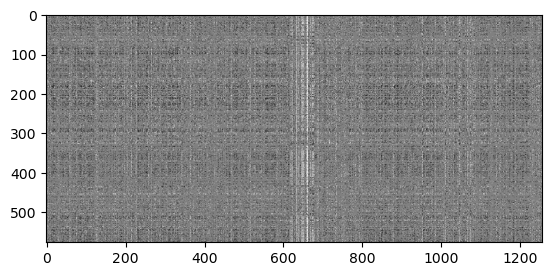

In [23]:
######### Display the vote matrix, rows and columns re-ordered according to their respective classes.
#fig, ax = plt.subplots(ncols=2)

#ax[0].imshow(votes, cmap='gray')
#ax[1]
plt.imshow(votes[np.argsort(row_classes), :][:, np.argsort(column_classes)], cmap='gray')
plt.show()

In [46]:
parameters_dict = {
    'nu_a':nu_a,
    'rho_a':rho_a,
    'nu_b':nu_b,
    'rho_b':rho_b,
    'nu_p': nu_p,
    'rho_p':rho_p,
    'nu_q':nu_q,
    'rho_q':rho_q,
    'tau_1':tau_1,
    'tau_2':tau_2,
    'mu_un':mu_un,
    'sigma_sq_a': sigma_sq_a,
    'sigma_sq_b':sigma_sq_b,
    'sigma_sq_p':sigma_sq_p,
    'sigma_sq_q':sigma_sq_q,
    'alpha_1':alpha_1,
    'alpha_2':alpha_2,
    'pi':pi,
}

save_objects_to_yaml(parameters_dict, 'trained_parameters.yaml')

In [9]:
loaded_parameters = load_objects_from_yaml('trained_parameters.yaml')
print(loaded_parameters)

{'alpha_1': [[0.09841310977935791], [0.07145793735980988], [0.11243176460266113], [0.1532304584980011], [0.09900952130556107], [0.1023215800523758], [0.07213222980499268], [0.08415855467319489], [0.09454812109470367], [0.11229667067527771]], 'alpha_2': [[0.11765486001968384, 0.1158323809504509, 0.10234834253787994, 0.09909115731716156, 0.08934255689382553, 0.09091036766767502, 0.11828500032424927, 0.10370327532291412, 0.0670798197388649, 0.09575212746858597]], 'mu_un': [[-3.929145336151123]], 'nu_a': [[2.465541362762451], [-3.0836904048919678], [0.4046456515789032], [1.7099677324295044], [0.2266729176044464], [0.406345009803772], [2.254512310028076], [0.9911666512489319], [2.4231767654418945], [1.582952618598938], [0.6675602197647095], [1.9688429832458496], [1.2316012382507324], [-1.4616894721984863], [-1.9601378440856934], [-0.7592905163764954], [2.102411985397339], [1.2256944179534912], [1.3686554431915283], [0.7678688764572144], [0.9809780716896057], [0.14097587764263153], [1.049564

In [11]:
pi = np.array(loaded_parameters['pi']).reshape(nq, nl)
tau_1 = np.array(loaded_parameters['tau_1'])
tau_2 = np.array(loaded_parameters['tau_2'])

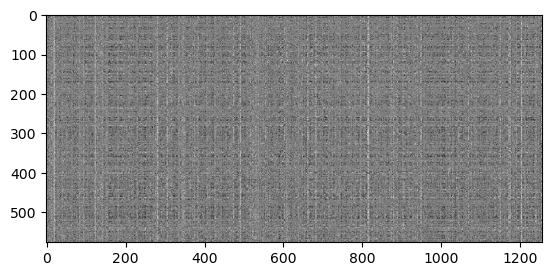

In [12]:
plt.imshow(votes, cmap='gray')

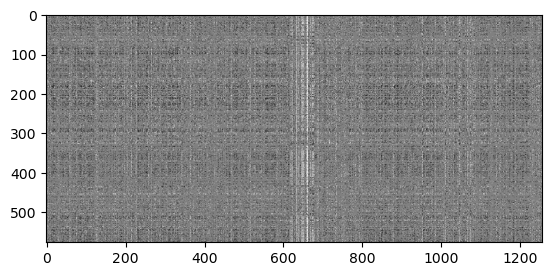

In [17]:
plt.imshow(votes[np.argsort(row_classes),:][:,np.argsort(column_classes)], cmap='gray')

In [33]:
print([[(c, deputes[i]['groupe']) for i, c in enumerate(row_classes) if c == nq] for nq in range(nq)])

[[(0, 'LT'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'SOC'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'UDI-AGIR'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LR'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'SOC'), (0, 'MODEM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'MODEM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'FI'), (0, 'LR'), (0, 'UDI-AGIR'), (0, 'LaREM'), (0, 'LaREM'), (0, 'NI'), (0, 'MODEM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LaREM'), (0, 'LR'), (0, 'MODEM'), (0, 'LaREM'), (0, 'LR'), (0, 'SOC')], [(1, 'LaREM'), (1, 'LaREM'), (1, 'LaREM'), (1, 'FI'), (1, 'LaREM'), (1, 'LaREM'), (1, 'GDR'), (1, 'FI'), (1, 'LT'), (1, 'FI'), (1, 'LaREM'), (1, 'NI'), (1, 'LR'), (1, 'LaREM'), (1, 'LaREM'), (1, 'LR'), (1, 'LR'), (1, 'LaREM'), (1, 'SOC'), (1, 'FI'), (1, 'LT'), (1, 'SOC'), (1,

In [167]:
gpc, df = groupes_politiques(row_classes, deputes)